In [1]:
from IPython.core.pylabtools import figsize

from neuralNet import ConvexNeuralNet, LinearNeuralNet, MatrixConvexNeuralNet, MatrixLinearNeuralNet
from pdes import LinearQuadraticRegulator2D, NonLinear2D, CuckerSmale
from enums import ActivationFunctionEnum, PositivityFunctionEnum, InitFunctionEnum
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.linalg
import torch
import wandb

from utils import setLogger

setLogger("training")

In [2]:
device_count = torch.cuda.device_count()
print(device_count)

for i in range(device_count):
    print(torch.cuda.get_device_name(i))

0


In [3]:
layers = [2, 32, 32, 1]
network = LinearNeuralNet(layers)
print( network.model )
gamma = {'data': 0, 'gradient': 0, 'residual': 1}
pde = LinearQuadraticRegulator2D( network, gamma )

lrs = [1e-2, 1e-3]
iterations = [1000, 2000]
interiorPointCount = 100

# Initialize wandb from the notebook
wandb.init(
    project="icnn",
    config={
        "layers": layers,  # Log the layers here
        "lrs": lrs,        # Log the learning rates
        "iterations": iterations,  # Log the iterations
        'interiorPointCount': interiorPointCount,
        "pde": pde.__class__.__name__,
        "network": network.__class__.__name__,
        "device": network.device
    }
)
config = wandb.config

resu = pde.train(
    interiorPointCount=interiorPointCount,
    dataPointCount=10,
    lrs=lrs,
    iterations=iterations,
    sampling='random'
    )

wandb.finish()

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=32, out_features=1, bias=True)
)


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: alexis-laignelet. Use `wandb login --relogin` to force relogin


2024-10-05 15:46:17,859 - training - INFO - 0 / 3000 (0 / 1000), lr:1.0e-02, loss:1.42e-01
2024-10-05 15:46:18,430 - training - INFO - 1000 / 3000 (0 / 2000), lr:1.0e-03, loss:4.67e-05
2024-10-05 15:46:19,003 - training - INFO - 2000 / 3000 (1000 / 2000), lr:1.0e-03, loss:4.37e-05


epoch,▁▅█
learning_rate,█▁▁
loss,█▁▁
epoch,2000
learning_rate,0.001
loss,4e-05


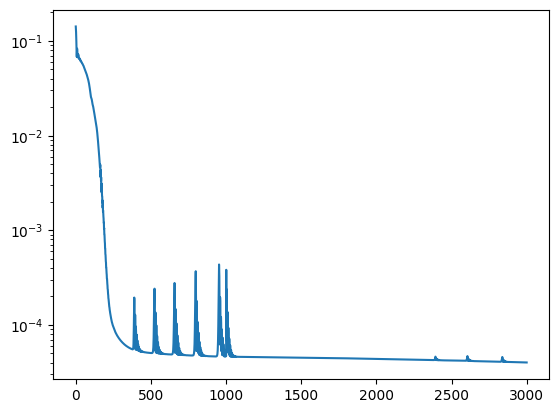

In [4]:
ax = resu['loss'].plot()
ax.set_yscale("log")

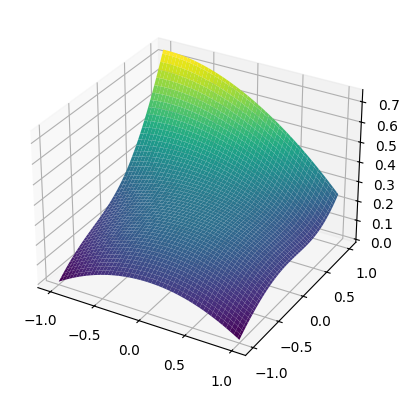

In [5]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = pde.getEvaluationPoints()

Z = pde.network.computeValueFunction(space).reshape(-1, 100) - pde.network.computeValueFunction(space).reshape(-1, 100).min()

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');

In [292]:
layers = [2, 32, 32, 3]
network = MatrixLinearNeuralNet(layers)
print( network.model )
gamma = {'data': 0, 'gradient': 0, 'residual': 1}
pde = LinearQuadraticRegulator2D( network, gamma )

lrs = [1e-2, 1e-3]
iterations = [1000, 2000]
interiorPointCount = 10

# Initialize wandb from the notebook
wandb.init(
    project="icnn",
    config={
        "layers": layers,  # Log the layers here
        "lrs": lrs,        # Log the learning rates
        "iterations": iterations,  # Log the iterations
        'interiorPointCount': interiorPointCount,
        "pde": pde.__class__.__name__,
        "network": network.__class__.__name__,
        "device": network.device
    }
)
config = wandb.config

resu = pde.train(
    interiorPointCount=interiorPointCount,
    dataPointCount=10,
    lrs=lrs,
    iterations=iterations,
    sampling='random'
    )
wandb.finish()

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=32, out_features=3, bias=True)
)


2024-10-02 22:43:38,105 - training - INFO - 0 / 3000 (0 / 1000), lr:1.0e-02, loss:1.83e-03
2024-10-02 22:43:39,567 - training - INFO - 1000 / 3000 (0 / 2000), lr:1.0e-03, loss:1.23e-08
2024-10-02 22:43:40,740 - training - INFO - 2000 / 3000 (1000 / 2000), lr:1.0e-03, loss:3.04e-10


epoch,▁▅█
learning_rate,█▁▁
loss,█▁▁
epoch,2000
learning_rate,0.001
loss,0.0


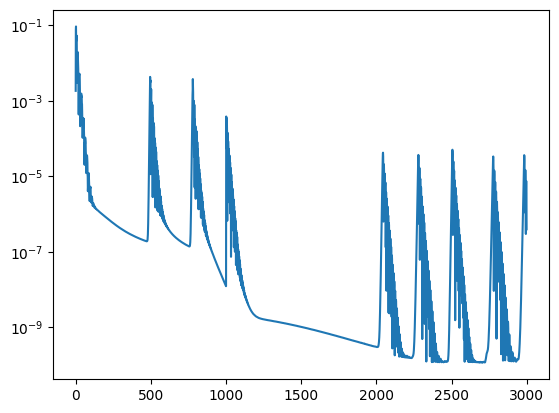

In [293]:
ax = resu['loss'].plot()
ax.set_yscale("log")

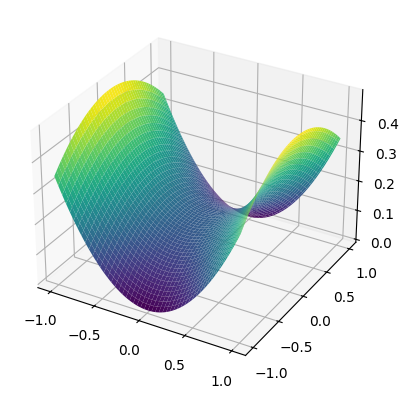

In [294]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = pde.getEvaluationPoints() 

Z = pde.network.computeValueFunction(space).reshape(-1, 100) - pde.network.computeValueFunction(space).reshape(-1, 100).min()

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');

### Convex neural net

In [497]:
layers = [2, 20, 20, 1]
network = ConvexNeuralNet( layers, activation=ActivationFunctionEnum.GELU, positivity=PositivityFunctionEnum.ICNN, init=InitFunctionEnum.CONVEX )
gamma = {'data': 0, 'gradient': 0, 'residual': 1}
pde = LinearQuadraticRegulator2D( network, gamma )

print(network.model)

weights = list(pde.network.model.parameters())
print(f"mean={weights[0].data.flatten().mean(): .3f}, std={weights[0].data.flatten().std(): .3f}")
print(f"mean={weights[2].data.flatten().mean(): .3f}, std={weights[2].data.flatten().std(): .3f}")
print(f"mean={weights[4].data.flatten().mean(): .3f}, std={weights[4].data.flatten().std(): .3f}")


lrs = [1e-3, 1e-4, 1e-5]
iterations = [1000, 2000, 5000]
interiorPointCount = 100

# Initialize wandb from the notebook
wandb.init(
    project="icnn",
    config={
        "layers": layers,  # Log the layers here
        "lrs": lrs,        # Log the learning rates
        "iterations": iterations,  # Log the iterations
        'interiorPointCount': interiorPointCount,
        "pde": pde.__class__.__name__,
        "network": network.__class__.__name__,
        "device": network.device
    }
)
config = wandb.config

resu = pde.train(
    interiorPointCount=interiorPointCount,
    dataPointCount=10,
    lrs=lrs,
    iterations=iterations,
    sampling='random'
    )

wandb.finish()

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): GELU(approximate='none')
  (2): ConvexLinear(in_features=20, out_features=20, bias=True)
  (3): GELU(approximate='none')
  (4): ConvexLinear(in_features=20, out_features=1, bias=True)
)
mean= 0.058, std= 0.468
mean= 0.080, std= 0.162
mean= 0.094, std= 0.242


2024-10-02 23:48:39,893 - training - INFO - 0 / 8000 (0 / 1000), lr:1.0e-03, loss:1.76e-01
2024-10-02 23:48:40,597 - training - INFO - 1000 / 8000 (0 / 2000), lr:1.0e-04, loss:3.80e-04
2024-10-02 23:48:41,218 - training - INFO - 2000 / 8000 (1000 / 2000), lr:1.0e-04, loss:9.98e-05
2024-10-02 23:48:41,809 - training - INFO - 3000 / 8000 (0 / 5000), lr:1.0e-05, loss:2.39e-05
2024-10-02 23:48:42,411 - training - INFO - 4000 / 8000 (1000 / 5000), lr:1.0e-05, loss:1.82e-05
2024-10-02 23:48:42,999 - training - INFO - 5000 / 8000 (2000 / 5000), lr:1.0e-05, loss:1.35e-05
2024-10-02 23:48:43,576 - training - INFO - 6000 / 8000 (3000 / 5000), lr:1.0e-05, loss:9.59e-06
2024-10-02 23:48:44,144 - training - INFO - 7000 / 8000 (4000 / 5000), lr:1.0e-05, loss:6.50e-06


epoch,▁▂▃▄▅▆▇█
learning_rate,█▂▂▁▁▁▁▁
loss,█▁▁▁▁▁▁▁
epoch,7000
learning_rate,1e-05
loss,1e-05


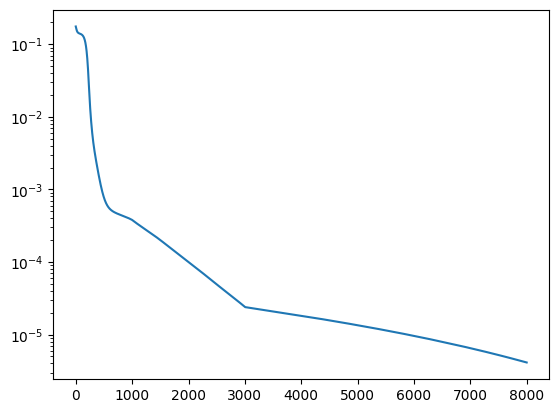

In [498]:
ax = resu['loss'].plot()
ax.set_yscale("log")

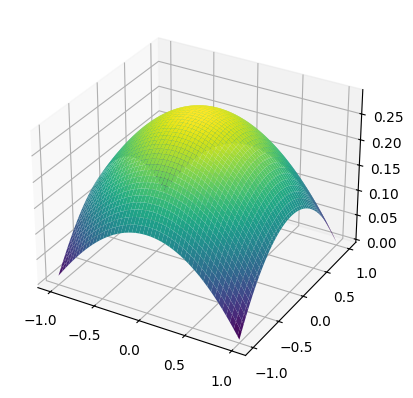

In [499]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = pde.getEvaluationPoints()

Z = pde.network.computeValueFunction(space).reshape(-1, 100) - pde.network.computeValueFunction(space).reshape(-1, 100).min()

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');

In [ ]:
layers = [2, 32, 32, 1]
network = ConvexNeuralNet( layers, activation=ActivationFunctionEnum.GELU, positivity=PositivityFunctionEnum.ICNN, init=InitFunctionEnum.CONVEX )
gamma = {'data': 0, 'gradient': 0, 'residual': 1}
pde = LinearQuadraticRegulator2D( network, gamma )

In [ ]:
weights = list(pde.network.model.parameters())

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

bins = np.linspace(-1, 1, 40)

ax = axs[0]
ax.hist( weights[0].data.flatten().numpy(), bins=bins)

ax = axs[1]
ax.hist( weights[2].data.flatten().numpy(), bins=bins)

ax = axs[2]
ax.hist( weights[4].data.flatten().numpy(), bins=bins);

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

bins = np.linspace(-1, 1, 40)

ax = axs[0]
ax.hist( weights[0].data.flatten().numpy(), bins=bins)

ax = axs[1]
ax.hist( weights[2].data.flatten().numpy(), bins=bins)

ax = axs[2]
ax.hist( weights[4].data.flatten().numpy(), bins=bins);

# Non linear example

In [11]:
layers = [2, 32, 32, 1]
network = LinearNeuralNet(layers)
print( network.model )
gamma = {'data': 0, 'gradient': 0, 'residual': 1}
pde = NonLinear2D( network, gamma )

lrs = [1e-2, 1e-3]
iterations = [1000, 2000]

resu = pde.train(
    interiorPointCount=10,
    dataPointCount=10,
    lrs=lrs,
    iterations=iterations,
    sampling='random'
    )

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=32, out_features=1, bias=True)
)
2024-09-14 15:22:25,191 - training - INFO - 0 / 3000 (0 / 1000), lr:1.0e-02, loss:1.55e-01 (data: 0.00e+00, grad: 0.00e+00, res: 1.55e-01)
2024-09-14 15:22:31,208 - training - INFO - 1000 / 3000 (0 / 2000), lr:1.0e-03, loss:1.01e-05 (data: 0.00e+00, grad: 0.00e+00, res: 1.01e-05)
2024-09-14 15:22:36,781 - training - INFO - 2000 / 3000 (1000 / 2000), lr:1.0e-03, loss:5.17e-06 (data: 0.00e+00, grad: 0.00e+00, res: 5.17e-06)


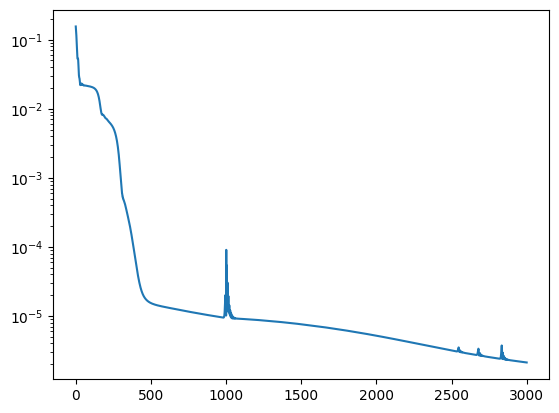

In [12]:
ax = resu['loss'].plot()
ax.set_yscale("log")

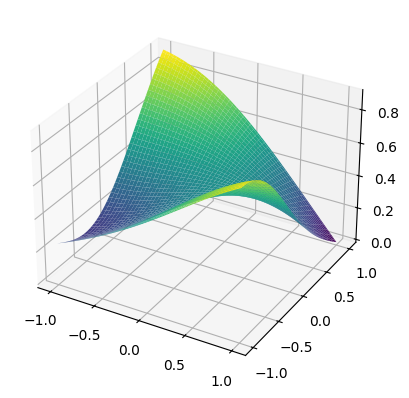

In [13]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = pde.getEvaluationPoints()

Z = pde.network.computeValueFunction(space).reshape(-1, 100) - pde.network.computeValueFunction(space).reshape(-1, 100).min()

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');

In [14]:
layers = [2, 32, 32, 3]
network = MatrixLinearNeuralNet(layers)
print( network.model )
gamma = {'data': 0, 'gradient': 0, 'residual': 1}
pde = NonLinear2D( network, gamma )

lrs = [1e-2, 1e-3]
iterations = [1000, 2000]

resu = pde.train(
    interiorPointCount=10,
    dataPointCount=10,
    lrs=lrs,
    iterations=iterations,
    sampling='random'
    )

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=32, out_features=3, bias=True)
)
2024-09-14 15:22:42,727 - training - INFO - 0 / 3000 (0 / 1000), lr:1.0e-02, loss:1.92e+00 (data: 0.00e+00, grad: 0.00e+00, res: 1.92e+00)
2024-09-14 15:23:00,040 - training - INFO - 1000 / 3000 (0 / 2000), lr:1.0e-03, loss:4.68e-04 (data: 0.00e+00, grad: 0.00e+00, res: 4.68e-04)
2024-09-14 15:23:18,188 - training - INFO - 2000 / 3000 (1000 / 2000), lr:1.0e-03, loss:6.64e-05 (data: 0.00e+00, grad: 0.00e+00, res: 6.64e-05)


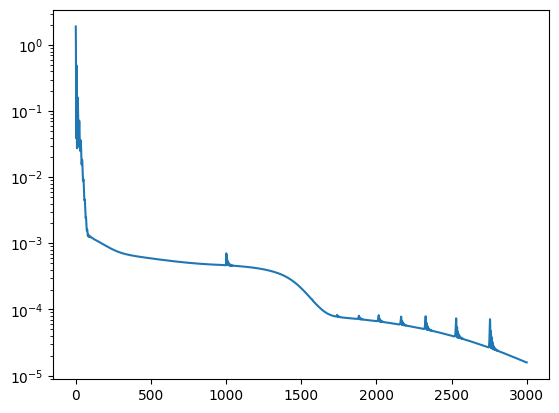

In [15]:
ax = resu['loss'].plot()
ax.set_yscale("log")

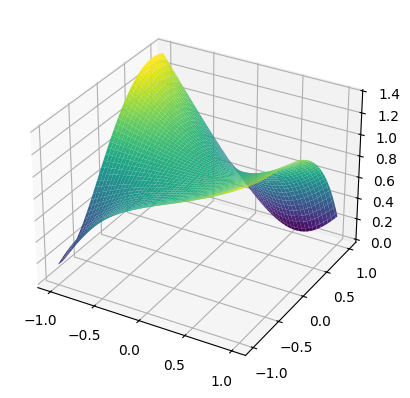

In [16]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = pde.getEvaluationPoints()

Z = pde.network.computeValueFunction(space).reshape(-1, 100) - pde.network.computeValueFunction(space).reshape(-1, 100).min()

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');

### Convex neural net

In [17]:
layers = [2, 32, 32, 1]
network = ConvexNeuralNet( layers, activation=ActivationFunctionEnum.GELU, positivity=PositivityFunctionEnum.CONVEX, init=InitFunctionEnum.TRADITIONAL )
gamma = {'data': 0, 'gradient': 0, 'residual': 1}
pde = NonLinear2D( network, gamma )

print(network.model)

lrs = [1e-1, 1e-2, 1e-3, 1e-4]
iterations = [1000, 2000, 3000, 4000]

resu = pde.train(
    interiorPointCount=500,
    dataPointCount=10,
    lrs=lrs,
    iterations=iterations,
    sampling='random'
    )

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): GELU(approximate='none')
  (2): ConvexLinear(in_features=32, out_features=32, bias=True)
  (3): GELU(approximate='none')
  (4): ConvexLinear(in_features=32, out_features=1, bias=True)
)
2024-09-14 15:23:37,388 - training - INFO - 0 / 10000 (0 / 1000), lr:1.0e-01, loss:9.98e+06 (data: 0.00e+00, grad: 0.00e+00, res: 9.98e+06)
2024-09-14 15:23:44,250 - training - INFO - 1000 / 10000 (0 / 2000), lr:1.0e-02, loss:6.55e+01 (data: 0.00e+00, grad: 0.00e+00, res: 6.55e+01)
2024-09-14 15:23:50,615 - training - INFO - 2000 / 10000 (1000 / 2000), lr:1.0e-02, loss:2.73e-02 (data: 0.00e+00, grad: 0.00e+00, res: 2.73e-02)
2024-09-14 15:23:56,835 - training - INFO - 3000 / 10000 (0 / 3000), lr:1.0e-03, loss:8.08e-03 (data: 0.00e+00, grad: 0.00e+00, res: 8.08e-03)
2024-09-14 15:24:02,933 - training - INFO - 4000 / 10000 (1000 / 3000), lr:1.0e-03, loss:1.13e-03 (data: 0.00e+00, grad: 0.00e+00, res: 1.13e-03)
2024-09-14 15:24:08,

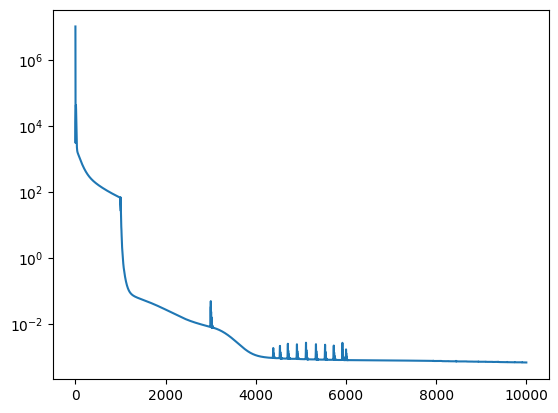

In [18]:
ax = resu['loss'].plot()
ax.set_yscale("log")

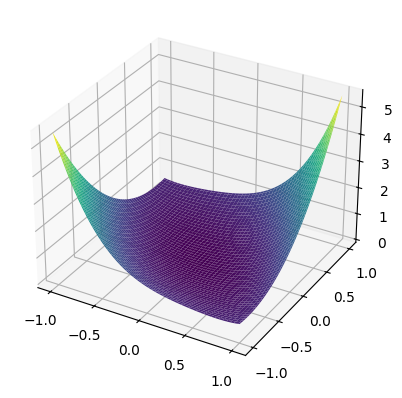

In [19]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = pde.getEvaluationPoints() 

Z = pde.network.computeValueFunction(space).reshape(-1, 100) - pde.network.computeValueFunction(space).reshape(-1, 100).min()

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');

In [20]:
layers = [2, 32, 32, 3]
network = MatrixConvexNeuralNet( layers, activation=ActivationFunctionEnum.RELU, positivity=PositivityFunctionEnum.ICNN, init=InitFunctionEnum.TRADITIONAL )
gamma = {'data': 0, 'gradient': 0, 'residual': 1}
pde = NonLinear2D( network, gamma )

print(network.model)

lrs = [1e-3, 1e-4, 1e-5]
iterations = [1000, 2000, 3000]

resu = pde.train(
    interiorPointCount=100,
    dataPointCount=10,
    lrs=lrs,
    iterations=iterations,
    sampling='random'
    )

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): ReLU()
  (2): ConvexLinear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): ConvexLinear(in_features=32, out_features=3, bias=True)
)
2024-09-14 15:24:41,122 - training - INFO - 0 / 6000 (0 / 1000), lr:1.0e-03, loss:1.02e+02 (data: 0.00e+00, grad: 0.00e+00, res: 1.02e+02)
2024-09-14 15:24:58,629 - training - INFO - 1000 / 6000 (0 / 2000), lr:1.0e-04, loss:9.67e-02 (data: 0.00e+00, grad: 0.00e+00, res: 9.67e-02)
2024-09-14 15:25:16,133 - training - INFO - 2000 / 6000 (1000 / 2000), lr:1.0e-04, loss:2.20e-02 (data: 0.00e+00, grad: 0.00e+00, res: 2.20e-02)
2024-09-14 15:25:32,786 - training - INFO - 3000 / 6000 (0 / 3000), lr:1.0e-05, loss:1.25e-02 (data: 0.00e+00, grad: 0.00e+00, res: 1.25e-02)
2024-09-14 15:25:50,200 - training - INFO - 4000 / 6000 (1000 / 3000), lr:1.0e-05, loss:1.05e-02 (data: 0.00e+00, grad: 0.00e+00, res: 1.05e-02)
2024-09-14 15:26:06,644 - training - INFO - 5000 / 6000 (2000

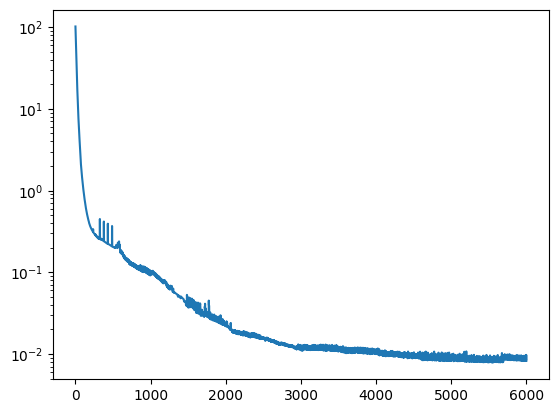

In [21]:
ax = resu['loss'].plot()
ax.set_yscale("log")

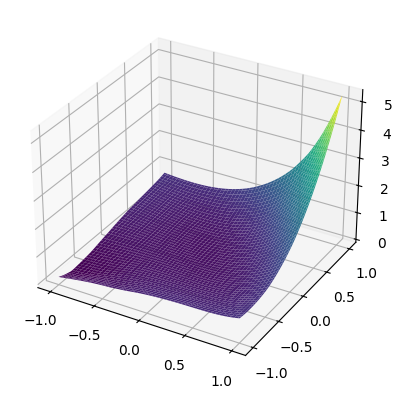

In [22]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = pde.getEvaluationPoints() 

Z = pde.network.computeValueFunction(space).reshape(-1, 100) - pde.network.computeValueFunction(space).reshape(-1, 100).min()

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');

In [23]:
layers = [2, 32, 32, 3]
network = MatrixConvexNeuralNet( layers, activation=ActivationFunctionEnum.RELU, positivity=PositivityFunctionEnum.ICNN, init=InitFunctionEnum.TRADITIONAL )
gamma = {'data': 0, 'gradient': 0, 'residual': 1}
pde = LinearQuadraticRegulator2D( network, gamma )

print(network.model)

lrs = [1e-1, 1e-2, 1e-3, 1e-4]
iterations = [1000, 2000, 3000, 4000]

resu = pde.train(
    interiorPointCount=500,
    dataPointCount=10,
    lrs=lrs,
    iterations=iterations,
    sampling='random'
    )

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): ReLU()
  (2): ConvexLinear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): ConvexLinear(in_features=32, out_features=3, bias=True)
)
2024-09-14 15:26:23,496 - training - INFO - 0 / 10000 (0 / 1000), lr:1.0e-01, loss:6.86e+03 (data: 0.00e+00, grad: 0.00e+00, res: 6.86e+03)
2024-09-14 15:26:40,447 - training - INFO - 1000 / 10000 (0 / 2000), lr:1.0e-02, loss:2.12e-05 (data: 0.00e+00, grad: 0.00e+00, res: 2.12e-05)
2024-09-14 15:26:57,281 - training - INFO - 2000 / 10000 (1000 / 2000), lr:1.0e-02, loss:5.24e-14 (data: 0.00e+00, grad: 0.00e+00, res: 5.24e-14)
2024-09-14 15:27:13,024 - training - INFO - 3000 / 10000 (0 / 3000), lr:1.0e-03, loss:9.57e-08 (data: 0.00e+00, grad: 0.00e+00, res: 9.57e-08)
2024-09-14 15:27:30,034 - training - INFO - 4000 / 10000 (1000 / 3000), lr:1.0e-03, loss:8.71e-15 (data: 0.00e+00, grad: 0.00e+00, res: 8.71e-15)
2024-09-14 15:27:47,001 - training - INFO - 5000 / 10000

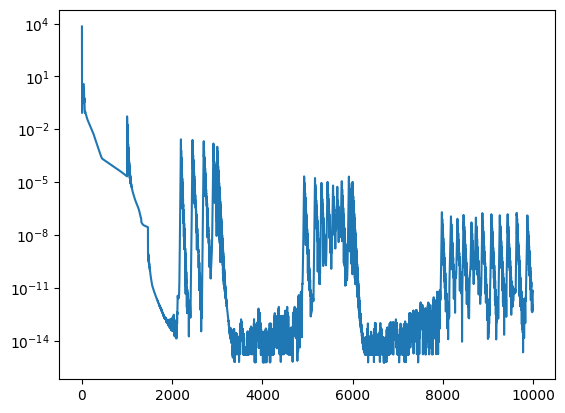

In [24]:
ax = resu['loss'].plot()
ax.set_yscale("log")

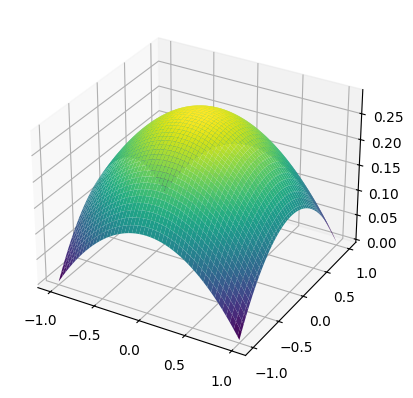

In [25]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = pde.getEvaluationPoints() 

Z = pde.network.computeValueFunction(space).reshape(-1, 100) - pde.network.computeValueFunction(space).reshape(-1, 100).min()

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');

# Cucker smale

dim = 2: ConvexNeuralNet( layers, activation=ActivationFunctionEnum.GELU, positivity=PositivityFunctionEnum.CONVEX, init=InitFunctionEnum.TRADITIONAL )

In [4]:
dim = 2
output_layer = sum( [i for i in range(2 * dim + 1)] )
print(output_layer)
quadraticForm = False
layers = [2 * dim, 50, 50, output_layer if quadraticForm else 1]

# Setup experiments
activation = ActivationFunctionEnum.GELU
positivity = PositivityFunctionEnum.CONVEX

network = ConvexNeuralNet( layers, activation=activation, positivity=positivity, init=InitFunctionEnum.TRADITIONAL )
gamma = {'data': 0, 'gradient': 0, 'residual': 1}
pde = CuckerSmale( network, gamma, dim=dim )

lrs = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
iterations = [1000, 2000, 5000, 10000, 10000]
interiorPointCount = 2000

# Initialize wandb from the notebook
wandb.init(
    project="icnn",
    config={
        "layers": layers,  # Log the layers here
        "lrs": lrs,        # Log the learning rates
        "iterations": iterations,  # Log the iterations
        'interiorPointCount': interiorPointCount,
        'activation': activation,
        'positivity': positivity,
        "pde": pde.__class__.__name__,
        "network": network.__class__.__name__,
        "device": network.device
    }
)
config = wandb.config

resu = pde.train(
    interiorPointCount=interiorPointCount,
    dataPointCount=0,
    lrs=lrs,
    iterations=iterations,
    sampling='random'
    )

wandb.finish()

10


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: alexis-laignelet. Use `wandb login --relogin` to force relogin


2024-09-26 18:49:15,360 - training - INFO - 0 / 28000 (0 / 1000), lr:1.0e-01, loss:4.53e+09
2024-09-26 18:49:19,093 - training - INFO - 1000 / 28000 (0 / 2000), lr:1.0e-02, loss:8.91e+04
2024-09-26 18:49:22,693 - training - INFO - 2000 / 28000 (1000 / 2000), lr:1.0e-02, loss:2.47e+00
2024-09-26 18:49:26,199 - training - INFO - 3000 / 28000 (0 / 5000), lr:1.0e-03, loss:1.13e+00
2024-09-26 18:49:29,917 - training - INFO - 4000 / 28000 (1000 / 5000), lr:1.0e-03, loss:1.16e-01
2024-09-26 18:49:33,540 - training - INFO - 5000 / 28000 (2000 / 5000), lr:1.0e-03, loss:6.90e-02
2024-09-26 18:49:37,045 - training - INFO - 6000 / 28000 (3000 / 5000), lr:1.0e-03, loss:5.14e-02
2024-09-26 18:49:40,660 - training - INFO - 7000 / 28000 (4000 / 5000), lr:1.0e-03, loss:4.39e-02
2024-09-26 18:49:44,345 - training - INFO - 8000 / 28000 (0 / 10000), lr:1.0e-04, loss:3.82e-02
2024-09-26 18:49:47,844 - training - INFO - 9000 / 28000 (1000 / 10000), lr:1.0e-04, loss:3.67e-02
2024-09-26 18:49:51,531 - trainin

epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
learning_rate,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,27000
learning_rate,1e-05
loss,0.01888


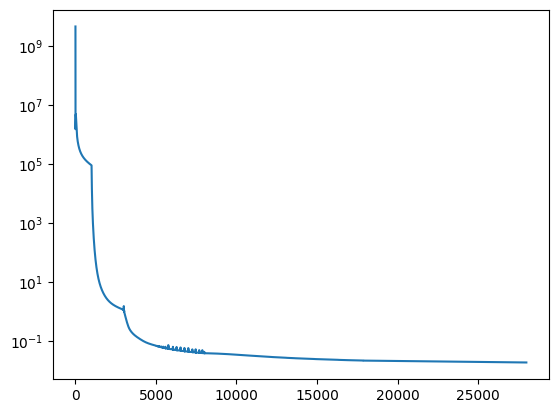

In [5]:
ax = resu['loss'].plot()
ax.set_yscale("log")

In [6]:
device = pde.network.device

n_samples = 1
T = 10
dt = 0.1
barx = 2 * torch.rand((n_samples, 2 * dim), requires_grad=True).to(device)

B = torch.vstack( [torch.zeros((dim, dim)), torch.eye(dim)] ).to(device).float()
Q = 1 / dim * torch.eye(2*dim, 2*dim).to(device).float()
R = 1 / dim * torch.eye(dim, dim).to(device).float()
beta = pde.beta

Bnp = B.cpu().numpy()
Qnp = Q.cpu().numpy()
Rnp = R.cpu().numpy()

In [7]:
def buildMatrixA(y):
    """ Build the small matrix A in 
    A_big = [[0,    I   ],
             [0, A_small]]
    """
    dim = y.shape[0]
    interationCoefficient = lambda yi, yj:  1. / ( 1. + (yi - yj)**2 )
    A_small = np.zeros( (dim, dim) )
    for i in range(dim):
        for j in range(dim):
            if i == j:
                sum_coeff = sum( [interationCoefficient(yi=y[i], yj=y[k]) for k in range(dim)] )
                A_small[i, j] = -1 / dim *  sum_coeff
            else:
                A_small[i, j] = 1 / dim * interationCoefficient(yi=y[i], yj=y[j])

    return A_small

def computeTrajectoriesNeuralNet(barx, dim, pde):
    resu = {}
    save_u = {}
    value_function = []
    for sample in range(barx.shape[0]):
        print(sample)
        new_barx_i = barx[sample, :]
        save_barx_i = np.zeros( (100, 2 * dim) )
        save_u_i = np.zeros( (100, dim) )
        
        for i, t in enumerate( np.arange(0, T, dt) ):
            # compute the control
            barx_i = new_barx_i
            gradV = pde.network.computeValueFunctionDerivative( barx_i.reshape(1, -1) ).T
            baru = - 1 / (2 * beta) * torch.inverse(R) @ B.T @ gradV
            save_barx_i[i] = new_barx_i.detach().cpu().numpy()
            save_u_i[i] = np.squeeze(  baru.detach().cpu().numpy() )

            # compute the dynamics
            A_small = buildMatrixA(y=barx_i[0 : dim])
            A = torch.tensor( np.block( [[ np.zeros((dim, dim)), np.eye(dim)], [np.zeros((dim, dim)), A_small]] ) ).float().to(device)
            new_barx_i = barx_i + A @ barx_i * dt + torch.squeeze(B @ baru) * dt
            
        # save the value function
        vi = np.sum( np.trapezoid(y=save_barx_i**2, dx=dt, axis=0) ) + np.sum( np.trapezoid(y=np.squeeze( save_u_i**2 ), dx=dt, axis=0) )

        resu[sample] = save_barx_i
        save_u[sample] = save_u_i
        value_function.append( vi )

    return resu, save_u, value_function

def computeTrajectoriesSDRE(barx, dim):
    resu = {}
    save_u = {}
    value_function = []
    for sample in range(barx.shape[0]):
        new_barx_i = barx[sample, :].cpu().detach().numpy()
        save_barx_i = np.zeros( (100, 2 * dim) )
        save_u_i = np.zeros( (100, dim) )
        
        for i, t in enumerate( np.arange(0, T, dt) ):
            barx_i = new_barx_i
            A_small = buildMatrixA(y=barx_i[0 : dim])
            A = np.block( [[ np.zeros((dim, dim)), np.eye(dim)], [np.zeros((dim, dim)), A_small]] )

            # compute the control
            P = scipy.linalg.solve_continuous_are(A, Bnp, Qnp, Rnp)
            baru = - 1 / (2 * beta) * np.linalg.inv(Rnp) @ Bnp.T @ P @ barx_i
            save_barx_i[i] = new_barx_i
            save_u_i[i] = baru
            
            # compute the dynamics
            new_barx_i = barx_i + A @ barx_i * dt + np.squeeze(Bnp @ baru) * dt
            
        # save the value function
        vi = np.sum( np.trapezoid(y=save_barx_i**2, dx=dt, axis=0) ) + np.sum( np.trapezoid(y=np.squeeze( save_u_i**2 ), dx=dt, axis=0) )

        resu[sample] = save_barx_i
        save_u[sample] = save_u_i
        value_function.append( vi )

    return resu, save_u, value_function

In [8]:
def plotResults(resu, save_u):
    fig, axs = plt.subplots(1, 3, figsize=(10, 3))

    ax = axs[0]
    for i in range(dim):
        ax.plot( np.linspace(0, T, 100), resu[0][:, i] )
    ax.set_xlabel('Time')
    ax.set_ylabel('Position')
    ax.axhline(0, color='grey', lw=0.5)
    ax.grid(alpha=0.2)

    ax = axs[1]
    for i in range(dim, 2 * dim):
        ax.plot( np.linspace(0, T, 100), resu[0][:, i] )
    ax.set_xlabel('Time')
    ax.set_ylabel('Velocity')
    ax.axhline(0, color='grey', lw=0.5)
    ax.grid(alpha=0.2)

    ax = axs[2]
    for i in range(dim):
        ax.plot( np.linspace(0, T, 100), save_u[0][:, i] )
    ax.set_xlabel('Time')
    ax.set_ylabel('Control')
    ax.axhline(0, color='grey', lw=0.5)
    ax.grid(alpha=0.2)

    fig.tight_layout()

In [9]:
resu_nn, save_u_nn, v_nn = computeTrajectoriesNeuralNet( barx, dim, pde )
resu_sdre, save_u_sdre, v_sdre = computeTrajectoriesSDRE( barx, dim )

0


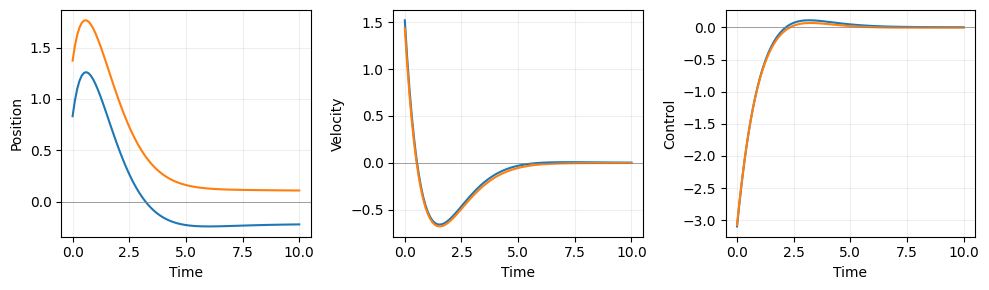

In [10]:
plotResults(resu_nn, save_u_nn)

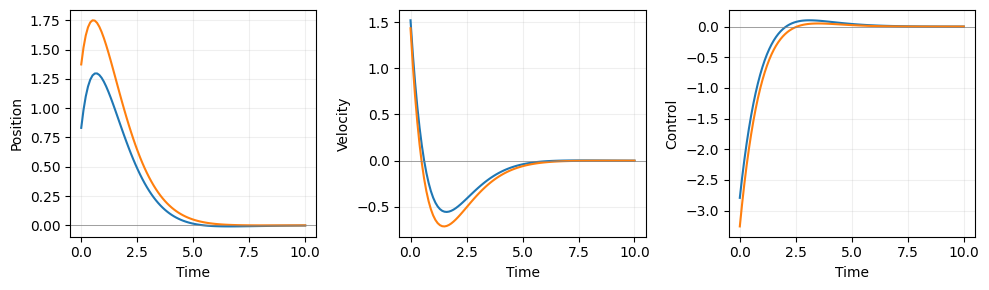

In [11]:
plotResults(resu_sdre, save_u_sdre)

# Activation function experiments Cucker Smale

Matrix output: 
- Gelu was the most promissing with ICNN. MISH could maybe work
- celu, hardtan, elu promissing for CONVEX

Value function output:
- selu for ICNN
- gelu, mish, silu, elu, celu, selu for CONVEX

In [54]:
def getLayersCukerSmale(dim, sizeHiddenLayer, countHiddenLayer, matrixOutput):
    layers = [2 * dim] + [sizeHiddenLayer] * countHiddenLayer
    layers += [sum( [i for i in range(2 * dim + 1)] )] if matrixOutput else [1]
    print(layers)
    return layers

In [55]:
from enums import ActivationFunctionEnum

dim = 2
layers = getLayersCukerSmale(dim=dim, sizeHiddenLayer=32, countHiddenLayer=2, matrixOutput=False)
init = InitFunctionEnum.TRADITIONAL
positivity = PositivityFunctionEnum.CONVEX

countExp = 1

res = []

limitedActivationFunction = [
    ActivationFunctionEnum.GELU,
    ActivationFunctionEnum.MISH,
    ActivationFunctionEnum.SILU,
    ActivationFunctionEnum.ELU,
    ActivationFunctionEnum.CELU,
    ActivationFunctionEnum.SELU
]

for activation in limitedActivationFunction:
    for i in range(countExp):
        network = ConvexNeuralNet( layers, activation=activation, positivity=positivity, init=init )
        gamma = {'data': 0, 'gradient': 0, 'residual': 1}
        pde = CuckerSmale( network, gamma, dim=dim )

        print(network.model)

        lrs = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
        iterations = [500, 1000, 2000, 5000, 5000]

        resu = pde.train(
            interiorPointCount=1000,
            dataPointCount=10,
            lrs=lrs,
            iterations=iterations,
            sampling='random'
            )
        
        res.append({"activation": activation.name, "loss": resu['loss'].iloc[-1], "pde": pde})

[4, 32, 32, 1]
Sequential(
  (0): Linear(in_features=4, out_features=32, bias=True)
  (1): GELU(approximate='none')
  (2): ConvexLinear(in_features=32, out_features=32, bias=True)
  (3): GELU(approximate='none')
  (4): ConvexLinear(in_features=32, out_features=1, bias=True)
)
2024-09-14 17:40:04,552 - training - INFO - 0 / 13500 (0 / 500), lr:1.0e-01, loss:4.67e+08 (data: 0.00e+00, grad: 0.00e+00, res: 4.67e+08)
2024-09-14 17:40:14,732 - training - INFO - 1000 / 13500 (500 / 1000), lr:1.0e-02, loss:5.32e+00 (data: 0.00e+00, grad: 0.00e+00, res: 5.32e+00)
2024-09-14 17:40:23,936 - training - INFO - 2000 / 13500 (500 / 2000), lr:1.0e-03, loss:1.14e+00 (data: 0.00e+00, grad: 0.00e+00, res: 1.14e+00)
2024-09-14 17:40:33,371 - training - INFO - 3000 / 13500 (1500 / 2000), lr:1.0e-03, loss:6.88e-01 (data: 0.00e+00, grad: 0.00e+00, res: 6.88e-01)
2024-09-14 17:40:42,669 - training - INFO - 4000 / 13500 (500 / 5000), lr:1.0e-04, loss:6.32e-01 (data: 0.00e+00, grad: 0.00e+00, res: 6.32e-01)
202

In [56]:
res = pd.DataFrame(res).sort_values("loss")
res

,activation,loss,pde
2,SILU,0.233681,<pdes.CuckerSmale object at 0x12d96c7a0>
0,GELU,0.518159,<pdes.CuckerSmale object at 0x12d903ec0>
1,MISH,0.674312,<pdes.CuckerSmale object at 0x12db0ef30>
4,CELU,0.986755,<pdes.CuckerSmale object at 0x12db560f0>
3,ELU,1.289132,<pdes.CuckerSmale object at 0x12d51a570>
5,SELU,9.842434,<pdes.CuckerSmale object at 0x12db9da90>


In [63]:
res[res['activation'] == ActivationFunctionEnum.MISH.name]

,activation,loss,pde
1,MISH,0.674312,<pdes.CuckerSmale object at 0x12db0ef30>


0


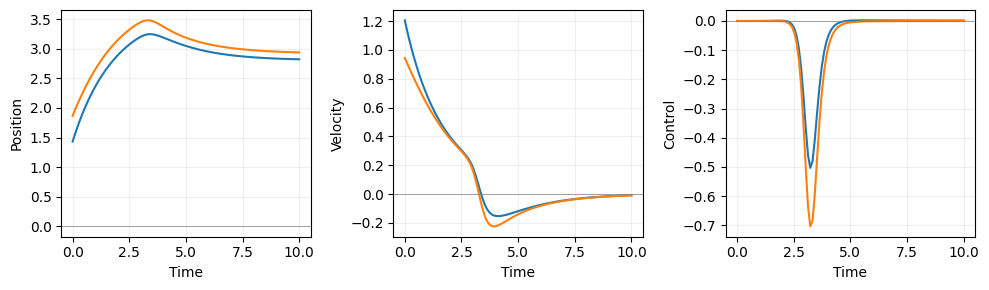

In [64]:
resu_nn, save_u_nn, v_nn = computeTrajectoriesNeuralNet( barx, dim, res[res['activation'] == ActivationFunctionEnum.SELU.name]['pde'].item() )
resu_sdre, save_u_sdre, v_sdre = computeTrajectoriesSDRE( barx, dim )
plotResults(resu_nn, save_u_nn)

# Activation function experiments

In [ ]:
from enums import ActivationFunctionEnum

layers = [2, 32, 32, 3]
init = InitFunctionEnum.TRADITIONAL
positivity = PositivityFunctionEnum.ICNN
equation = NonLinear2D

countExp = 1

res = []

# limitedActivationFunction = [
#     ActivationFunctionEnum.SOFTMAX,
#     ActivationFunctionEnum.TANH
# ]

for activation in ActivationFunctionEnum:
    for i in range(countExp):
        network = MatrixConvexNeuralNet( layers, activation=activation, positivity=positivity, init=init )
        gamma = {'data': 0, 'gradient': 0, 'residual': 1}
        pde = equation( network, gamma )

        print(network.model)

        lrs = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
        iterations = [1000, 2000, 5000, 10000, 10000]

        resu = pde.train(
            interiorPointCount=2000,
            dataPointCount=10,
            lrs=lrs,
            iterations=iterations,
            sampling='random'
            )
        
        x = np.linspace(-1, 1, 100)
        y = np.linspace(-1, 1, 100)

        X, Y = np.meshgrid(x, y)
        space = pde.getEvaluationPoints()

        Z = pde.network.computeValueFunction(space).reshape(-1, 100) - pde.network.computeValueFunction(space).reshape(-1, 100).min()
        res.append({"activation": activation.name, "loss": resu['loss'].iloc[-1], "value": Z})

In [230]:
res = pd.DataFrame(res).sort_values("loss")
res

,activation,loss,value
5,PRELU,3.512507e-14,"[[tensor(0.9773, grad_fn=<UnbindBackward0>), t..."
21,SOFTMAX,1.833638e-10,"[[tensor(0.9767, grad_fn=<UnbindBackward0>), t..."
20,SOFTMIN,9.292636e-10,"[[tensor(0.9747, grad_fn=<UnbindBackward0>), t..."
19,TANHSHRINK,4.645108e-07,"[[tensor(0., grad_fn=<UnbindBackward0>), tenso..."
18,TANH,8.203167e-07,"[[tensor(0., grad_fn=<UnbindBackward0>), tenso..."
12,SIGMOID,1.432424e-06,"[[tensor(0.9111, grad_fn=<UnbindBackward0>), t..."
17,SOFTSIGN,1.653420e-06,"[[tensor(0.9803, grad_fn=<UnbindBackward0>), t..."
14,MISH,3.751081e-05,"[[tensor(0.9730, grad_fn=<UnbindBackward0>), t..."
11,GELU,4.569376e-04,"[[tensor(0.6732, grad_fn=<UnbindBackward0>), t..."
10,CELU,6.791636e-04,"[[tensor(0., grad_fn=<UnbindBackward0>), tenso..."


In [231]:
resActivation = res.groupby("activation")['value'].first()
resActivation.index

Index(['CELU', 'ELU', 'GELU', 'HARDSHRINK', 'HARDTANH', 'LEAKYRELU',
       'LOGSIGMOID', 'LOGSOFTMAX', 'MISH', 'PRELU', 'RELU', 'RELU6', 'RRELU',
       'SELU', 'SIGMOID', 'SILU', 'SOFTMAX', 'SOFTMIN', 'SOFTPLUS',
       'SOFTSHRINK', 'SOFTSIGN', 'TANH', 'TANHSHRINK'],
      dtype='object', name='activation')

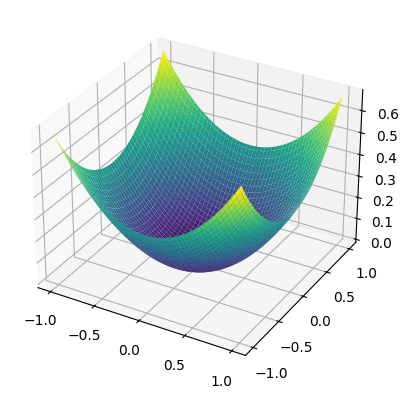

In [258]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = pde.getEvaluationPoints()

Z = resActivation[ActivationFunctionEnum.GELU.name]
# Z = res[res['activation'] == ActivationFunctionEnum.RELU.name]['value'].values[8]


ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');

In [ ]:
# plot activation functions

def celu(x, alpha=1.0):
    return np.maximum(0, x) + np.minimum(0, alpha * (np.exp(x / alpha) - 1))

def elu(x, alpha=1.0):
    return np.where(x > 0, x, alpha * (np.exp(x) - 1))

def gelu(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))

def mish(x):
    return x * np.tanh(np.log1p(np.exp(x)))

x = np.linspace(-3, 3, 400)

plt.figure(figsize=(6, 4))

plt.plot(x, celu(x), label='CELU', linestyle='--')
plt.plot(x, elu(x), label='ELU', linestyle='--')
plt.plot(x, gelu(x), label='GELU', linestyle='--')
plt.plot(x, mish(x), label='Mish', linestyle='--')

plt.title('Activation Functions')
plt.xlabel('x')
plt.ylabel('Activation')
plt.legend()
plt.grid(True)

plt.show()

# Reproduce the quadrant

In [12]:
import torch

# First, let's include our MirrorDescent optimizer
class MirrorDescent(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, weight_decay=0):
        defaults = dict(lr=lr, weight_decay=weight_decay)
        super(MirrorDescent, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                
                d_p = p.grad
                if group['weight_decay'] != 0:
                    d_p = d_p.add(p, alpha=group['weight_decay'])
                
                # Mirror map: negative entropy
                # Gradient of mirror map: log(p)
                # Inverse gradient of mirror map: exp(p)
                p.copy_(torch.exp(torch.log(torch.abs(p) + 1e-8) - group['lr'] * d_p))
                
                # Projection onto the positive orthant
                p.clamp_(min=0)


Training with Mirror Descent
Epoch [100/1000], Loss: 0.0119
Epoch [200/1000], Loss: 0.0069
Epoch [300/1000], Loss: 0.0057
Epoch [400/1000], Loss: 0.0055
Epoch [500/1000], Loss: 0.0040
Epoch [600/1000], Loss: 0.0105
Epoch [700/1000], Loss: 0.0062
Epoch [800/1000], Loss: 0.0018
Epoch [900/1000], Loss: 0.0025
Epoch [1000/1000], Loss: 0.0043

Training with SGD
Epoch [100/1000], Loss: 0.0881
Epoch [200/1000], Loss: 0.0585
Epoch [300/1000], Loss: 0.0493
Epoch [400/1000], Loss: 0.0428
Epoch [500/1000], Loss: 0.0373
Epoch [600/1000], Loss: 0.0348
Epoch [700/1000], Loss: 0.0306
Epoch [800/1000], Loss: 0.0301
Epoch [900/1000], Loss: 0.0269
Epoch [1000/1000], Loss: 0.0255

Training with Adam
Epoch [100/1000], Loss: 0.0116
Epoch [200/1000], Loss: 0.0066
Epoch [300/1000], Loss: 0.0048
Epoch [400/1000], Loss: 0.0036
Epoch [500/1000], Loss: 0.0030
Epoch [600/1000], Loss: 0.0019
Epoch [700/1000], Loss: 0.0045
Epoch [800/1000], Loss: 0.0015
Epoch [900/1000], Loss: 0.0013
Epoch [1000/1000], Loss: 0.001

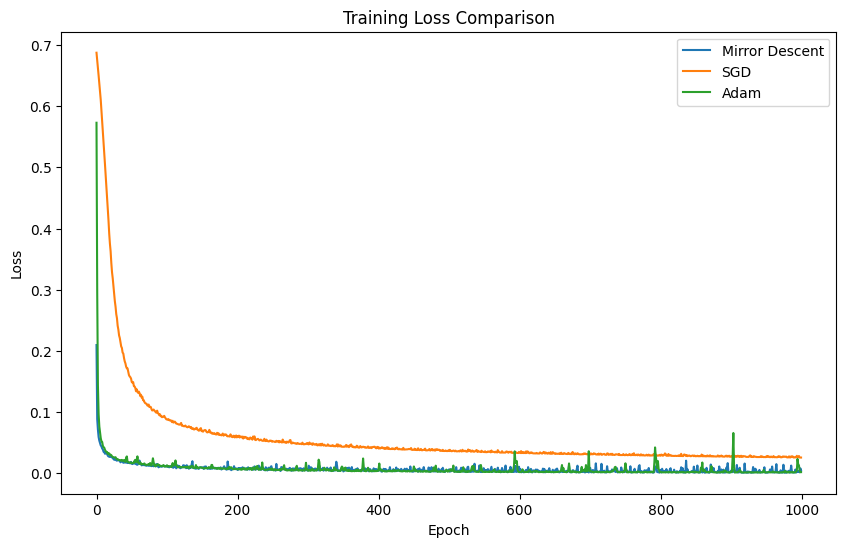


Test Accuracies:
Epoch [100/1000], Loss: 0.0088
Epoch [200/1000], Loss: 0.0051
Epoch [300/1000], Loss: 0.0038
Epoch [400/1000], Loss: 0.0033
Epoch [500/1000], Loss: 0.0036
Epoch [600/1000], Loss: 0.0048
Epoch [700/1000], Loss: 0.0020
Epoch [800/1000], Loss: 0.0012
Epoch [900/1000], Loss: 0.0014
Epoch [1000/1000], Loss: 0.0055
Mirror Descent: 1.0000
Epoch [100/1000], Loss: 0.0851
Epoch [200/1000], Loss: 0.0584
Epoch [300/1000], Loss: 0.0466
Epoch [400/1000], Loss: 0.0400
Epoch [500/1000], Loss: 0.0367
Epoch [600/1000], Loss: 0.0327
Epoch [700/1000], Loss: 0.0304
Epoch [800/1000], Loss: 0.0297
Epoch [900/1000], Loss: 0.0268
Epoch [1000/1000], Loss: 0.0254
SGD: 1.0000
Epoch [100/1000], Loss: 0.0112
Epoch [200/1000], Loss: 0.0077
Epoch [300/1000], Loss: 0.0167
Epoch [400/1000], Loss: 0.0053
Epoch [500/1000], Loss: 0.0034
Epoch [600/1000], Loss: 0.0092
Epoch [700/1000], Loss: 0.0020
Epoch [800/1000], Loss: 0.0020
Epoch [900/1000], Loss: 0.0014
Epoch [1000/1000], Loss: 0.0011
Adam: 1.0000


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

class ImprovedMirrorDescent(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, alpha=0.99, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(ImprovedMirrorDescent, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                
                grad = p.grad
                state = self.state[p]

                # Initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg_sq'] = torch.zeros_like(p)

                exp_avg_sq = state['exp_avg_sq']
                alpha = group['alpha']

                state['step'] += 1

                # Update moving average of squared gradients
                exp_avg_sq.mul_(alpha).addcmul_(grad, grad, value=1 - alpha)

                # Compute adaptive learning rate
                step_size = group['lr'] / (exp_avg_sq.sqrt() + group['eps'])

                # Mirror descent step
                p.addcmul_(grad, step_size, value=-1)

        return loss

# MirrorDescent optimizer (as defined earlier)
class MirrorDescent(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, weight_decay=0):
        defaults = dict(lr=lr, weight_decay=weight_decay)
        super(MirrorDescent, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                
                d_p = p.grad
                if group['weight_decay'] != 0:
                    d_p = d_p.add(p, alpha=group['weight_decay'])
                
                p.copy_(torch.exp(torch.log(torch.abs(p) + 1e-8) - group['lr'] * d_p))
                p.clamp_(min=0)

        return loss

# Simple neural network
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Generate data
X = torch.randn(1000, 2)
y = (X[:, 0] + X[:, 1] > 0).float().unsqueeze(1)
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Training function
def train_model(model, optimizer, num_epochs=1000):
    losses = []
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = F.binary_cross_entropy_with_logits(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    return losses

# Train with different optimizers
optimizers = {
    'Mirror Descent': lambda m: ImprovedMirrorDescent(m.parameters(), lr=0.01),
    'SGD': lambda m: torch.optim.SGD(m.parameters(), lr=0.01),
    'Adam': lambda m: torch.optim.Adam(m.parameters(), lr=0.01)
}

results = {}

for name, opt_func in optimizers.items():
    print(f"\nTraining with {name}")
    model = SimpleNet()
    optimizer = opt_func(model)
    losses = train_model(model, optimizer)
    results[name] = losses

# Plot results
plt.figure(figsize=(10, 6))
for name, losses in results.items():
    plt.plot(losses, label=name)
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate models
def evaluate_model(model, X, y):
    model.eval()
    with torch.no_grad():
        predictions = (model(X) > 0).float()
        accuracy = (predictions == y).float().mean()
    return accuracy.item()

test_X = torch.randn(100, 2)
test_y = (test_X[:, 0] + test_X[:, 1] > 0).float().unsqueeze(1)

print("\nTest Accuracies:")
for name, opt_func in optimizers.items():
    model = SimpleNet()
    optimizer = opt_func(model)
    train_model(model, optimizer)
    accuracy = evaluate_model(model, test_X, test_y)
    print(f"{name}: {accuracy:.4f}")

In [14]:
import torch
from torch.optim import Optimizer

class CorrectPositiveMirrorDescent(Optimizer):
    def __init__(self, params, lr=1e-3, eps=1e-8):
        defaults = dict(lr=lr, eps=eps)
        super(CorrectPositiveMirrorDescent, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                
                grad = p.grad
                state = self.state[p]

                # Mirror Descent update with negative entropy mirror map
                p.data.copy_(
                    torch.exp(torch.log(p + group['eps']) - group['lr'] * grad)
                )

        return loss

# Modified SimpleNet to initialize with positive weights
class PositiveSimpleNet(nn.Module):
    def __init__(self):
        super(PositiveSimpleNet, self).__init__()
        self.fc1 = nn.Linear(2, 10, bias=False)
        self.fc2 = nn.Linear(10, 1, bias=False)
        self.initialize_positive()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def initialize_positive(self):
        with torch.no_grad():
            self.fc1.weight.abs_()
            self.fc2.weight.abs_()

# Minimalistic Neural Net

In [6]:
import torch
from torch.optim import Optimizer
import torch.nn as nn

class CorrectPositiveMirrorDescent(Optimizer):
    def __init__(self, params, lr=1e-3, eps=1e-8):
        defaults = dict(lr=lr, eps=eps)
        super(CorrectPositiveMirrorDescent, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                
                grad = p.grad
                state = self.state[p]

                # Mirror Descent update with negative entropy mirror map
                p.data.copy_(
                    torch.exp(torch.log(p + group['eps']) - group['lr'] * grad)
                )

        return loss
    

class MinimalQuadraticNetwork(nn.Module):
    def __init__(self):
        super(MinimalQuadraticNetwork, self).__init__()
        # Initialize two positive weights
        self.weights = nn.Parameter(torch.rand(2))

    # def forward(self, x):
    #     # Ensure weights are positive
    #     positive_weights = torch.exp(self.weights)
        
    #     # Compute 1/2 x^T P x
    #     # Where P is a diagonal matrix with our two weights
    #     return 0.5 * torch.sum(positive_weights * x**2, dim=1)
    
    def forward(self, x):
        return 0.5 * torch.sum(self.weights * x**2, dim=1)

In [7]:
import torch
import torch.nn as nn

# Define the network and optimizer
net = MinimalQuadraticNetwork()
optimizer = CorrectPositiveMirrorDescent(net.parameters(), lr=0.01)

# Dummy data: several 2D examples (each row is a 2D point)
x = torch.tensor([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])

# Forward pass: get output for each input point
output = net(x)

# Print output vector
print(f"Output: {output}")

# Compute gradient and update weights
output.sum().backward()  # Summing output to get a scalar loss for backpropagation
optimizer.step()

# Print updated weights
print(f"Updated weights: {torch.exp(net.weights).tolist()}")


Output: tensor([ 0.9277,  4.6148, 11.2421], grad_fn=<MulBackward0>)
Updated weights: [1.3546501398086548, 1.3261127471923828]


In [138]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from neuralNet import BaseNeuralNet
import logging

# Set up logger
logger = logging.getLogger("training")

class AdaptedQuadraticNetwork(BaseNeuralNet):
    def __init__(self):
        layers = [2]  # Assuming you have two weights as in your MinimalQuadraticNetwork
        super(AdaptedQuadraticNetwork, self).__init__(layers)
        self._buildModel(layers)

    def _buildLayers(self, layers):
        # Not used in this specific example, but could be extended if needed
        pass

    def _buildModel(self, layers):
        # Use your MinimalQuadraticNetwork as the model
        self.model = MinimalQuadraticNetwork()
        self.model.to(self.device)

    def computeValueFunction(self, x):
        # Forward pass through the network
        return self.model(x)

    def train(self, feedDict, lrs, iterations):
        """
        Override the train method to use your custom optimizer.
        """
        gamma = feedDict["gamma"]
        lossFunction = feedDict["lossFunction"]
        xInt = feedDict["xInt"].to(self.device)
        xData = feedDict["xData"].to(self.device)

        self.writer.add_graph(self.model, xData)

        gradInt = torch.zeros(xInt.shape).to(self.device)
        yData = torch.zeros((xData.shape[0], 1)).to(self.device)
        gradData = torch.zeros(xData.shape).to(self.device)

        epochTotal = 0
        info = []

        for lr, iteration in zip(lrs, iterations):
            # Initialize your custom optimizer
            self.optimizer = CorrectPositiveMirrorDescent(params=self.model.parameters(), lr=lr)

            # self.optimizer = torch.optim.Adam(
            #     params=self.model.parameters(), lr=lr, weight_decay=0.0
            # )

            for epoch in range(iteration):
                if gamma["data"] > 0.0:
                    yData = self.computeValueFunction(xData)

                if gamma["gradient"] > 0.0:
                    gradData = self._computeValueFunctionDerivative(xData)

                if gamma["residual"] > 0.0:
                    gradInt = self._computeValueFunctionDerivative(xInt)

                lossData, lossGrad, lossResidual = lossFunction(
                    xInt, gradInt, yData, gradData
                )
                loss = (
                    gamma["data"] * lossData
                    + gamma["gradient"] * lossGrad
                    + gamma["residual"] * lossResidual
                )
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                if epochTotal % 1000 == 0:
                    logger.info(
                        f"{epochTotal} / {sum(iterations)} ({epoch} / {iteration}), "
                        f"lr:{lr:.1e}, loss:{loss.item():.2e} (data: {lossData.item():.2e}, "
                        f"grad: {lossGrad.item():.2e}, res: {lossResidual.item():.2e})"
                    )

                epochTotal += 1

                info_dict = {
                    "weights": self.model.weights.detach().cpu().numpy().tolist(),
                    "xData": xData,
                    "epoch": epochTotal,
                    "loss": loss.detach().cpu().numpy().item(),
                }
                info.append(info_dict)

        self.writer.close()

        return pd.DataFrame(info)


In [156]:
network = AdaptedQuadraticNetwork()
gamma = {'data': 0, 'gradient': 0, 'residual': 1}
pde = LinearQuadraticRegulator2D( network, gamma )

print(network.model)

lrs = [1e-2, 1e-3]
iterations = [1000, 2000]

resu = pde.train(
    interiorPointCount=500,
    dataPointCount=10,
    lrs=lrs,
    iterations=iterations,
    sampling='random'
    )

MinimalQuadraticNetwork()
2024-09-01 13:16:25,172 - training - INFO - 0 / 3000 (0 / 1000), lr:1.0e-02, loss:1.27e-01 (data: 0.00e+00, grad: 0.00e+00, res: 1.27e-01)
2024-09-01 13:16:26,520 - training - INFO - 1000 / 3000 (0 / 2000), lr:1.0e-03, loss:6.73e-05 (data: 0.00e+00, grad: 0.00e+00, res: 6.73e-05)
2024-09-01 13:16:27,833 - training - INFO - 2000 / 3000 (1000 / 2000), lr:1.0e-03, loss:1.85e-05 (data: 0.00e+00, grad: 0.00e+00, res: 1.85e-05)


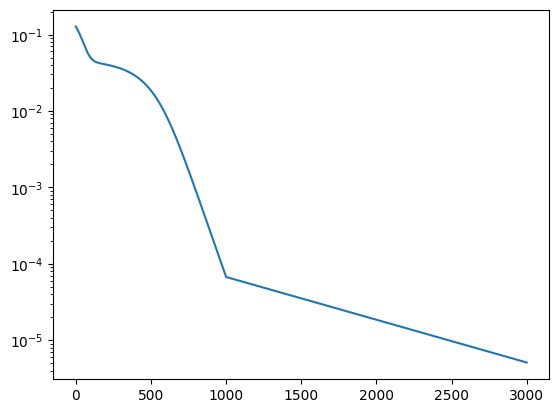

In [157]:
ax = resu['loss'].plot()
ax.set_yscale("log")

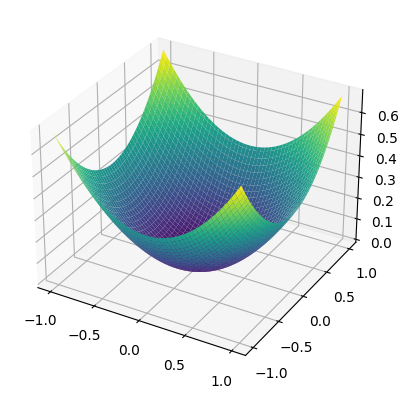

In [158]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = pde.getEvaluationPoints() 

Z = pde.network.computeValueFunction(space).reshape(-1, 100) - pde.network.computeValueFunction(space).reshape(-1, 100).min()

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');

In [159]:
def lossFunction(x, y,  beta):
    def riccatiEquation(z):
        return z**2 - 4 * beta * z - 2 * beta
    return np.diag([riccatiEquation(x), riccatiEquation(y)])

def scalarisedLossFunction(x, y, beta=0.1):
    return np.linalg.norm( lossFunction(x, y, beta) )

In [160]:
x = np.linspace(-0.6, 1, 100)
y = np.linspace(-0.6, 1, 100)

X, Y = np.meshgrid(x, y)
vectorisedScalarisedLossFunction = np.vectorize(scalarisedLossFunction)
Zresidual = vectorisedScalarisedLossFunction(X, Y)

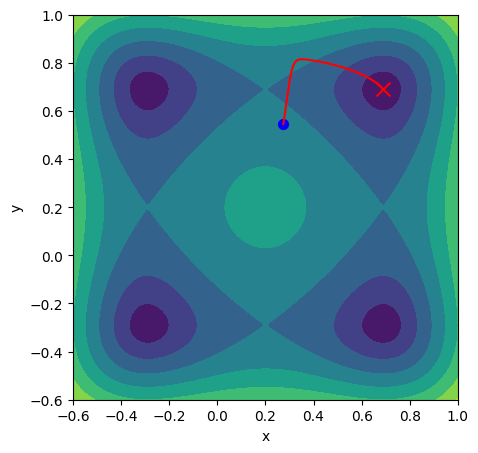

In [161]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.contourf(X, Y, Zresidual)

# Extract x and y coordinates
w1 = [weights[0] for weights in resu['weights']]
w2 = [weights[1] for weights in resu['weights']]

# Plotting the gradient descent path
ax.plot(w1, w2, label='Gradient Descent Path', color='red')
ax.scatter(w1[0], w2[0], color='blue', label='Start', s=50)  # Start point
ax.scatter(w1[-1], w2[-1], color='red', label='End', marker='x', s=100)  # End point
ax.set_xlabel('x')
ax.set_ylabel('y');

plt.gca().set_aspect('equal', adjustable='box')

# ax = fig.add_subplot(1, 2, 2, projection='3d')
# ax.plot_surface(X, Y, Zresidual, cmap='viridis')
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')
# ax.set_zlim(0,1);

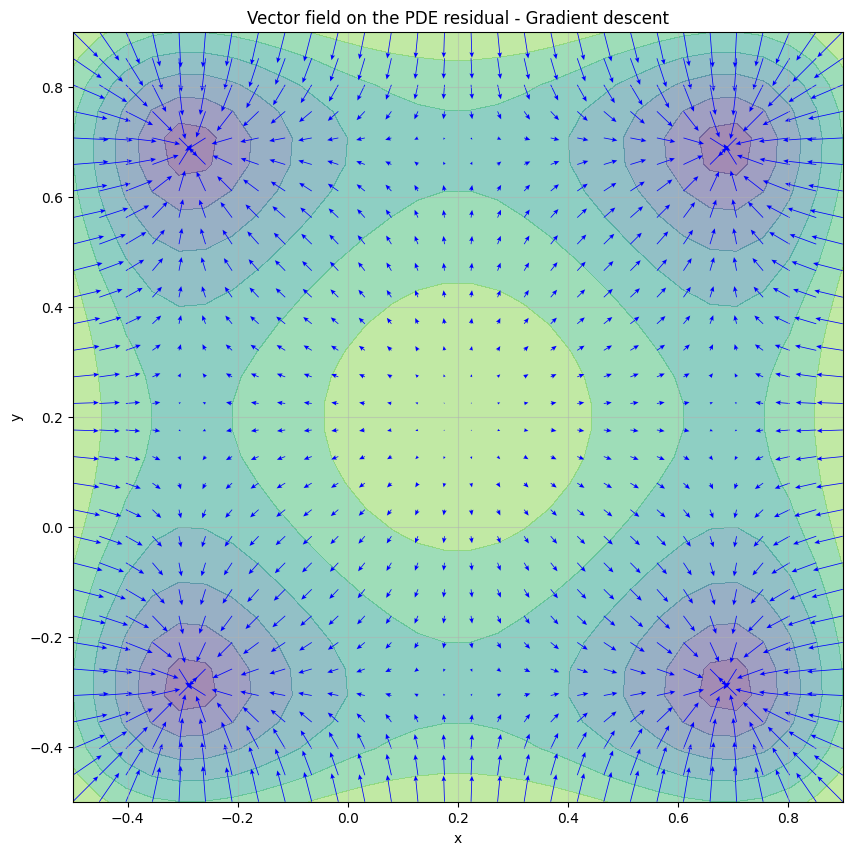

In [153]:
import numpy as np
import matplotlib.pyplot as plt

# Define the loss function
def lossFunction(x, y, beta):
    def riccatiEquation(z):
        return z**2 - 4 * beta * z - 2 * beta
    return np.diag([riccatiEquation(x), riccatiEquation(y)])

# Define the scalarized loss function
def scalarisedLossFunction(x, y, beta=0.1):
    return np.linalg.norm(lossFunction(x, y, beta))

# Define the gradient calculation using finite differences
def compute_gradient(f, x, y, beta, h=1e-5):
    dfdx = (f(x + h, y, beta) - f(x - h, y, beta)) / (2 * h)
    dfdy = (f(x, y + h, beta) - f(x, y - h, beta)) / (2 * h)
    return dfdx, dfdy

# Generate a grid of points
x_values = np.linspace(-0.5, 0.9, 30)
y_values = np.linspace(-0.5, 0.9, 30)
X, Y = np.meshgrid(x_values, y_values)

# Prepare storage for gradients
U = np.zeros_like(X)
V = np.zeros_like(Y)

# Compute gradients at each point on the grid
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        dfdx, dfdy = compute_gradient(scalarisedLossFunction, X[i, j], Y[i, j], beta=0.1)
        U[i, j] = -dfdx  # Negate the gradient for descent direction
        V[i, j] = -dfdy  # Negate the gradient for descent direction


Z = np.array([[scalarisedLossFunction(x, y, beta=0.1) for x in x_values] for y in y_values])

# Plot the vector field using quiver
plt.figure(figsize=(10, 10))
plt.contourf(X, Y, Z, alpha=0.5)
plt.quiver(X, Y, U, V, color='blue', scale=30, scale_units='width', width=0.001, headwidth=6, headlength=7, headaxislength=6)

# plt.contour(X, Y, Z, levels=20, cmap='viridis', linewidths=0.5)

# Ensure the x-axis and y-axis have the same scale
plt.gca().set_aspect('equal', adjustable='box')

plt.grid(alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Vector field on the PDE residual - Gradient descent')
plt.show()


/var/folders/x3/rv50w10j3md436d0633nrr600000gn/T/ipykernel_31444/1928854322.py:14: RuntimeWarning: invalid value encountered in log
  updated_point = np.exp(np.log(current_point + 1e-8) - learning_rate * grad)


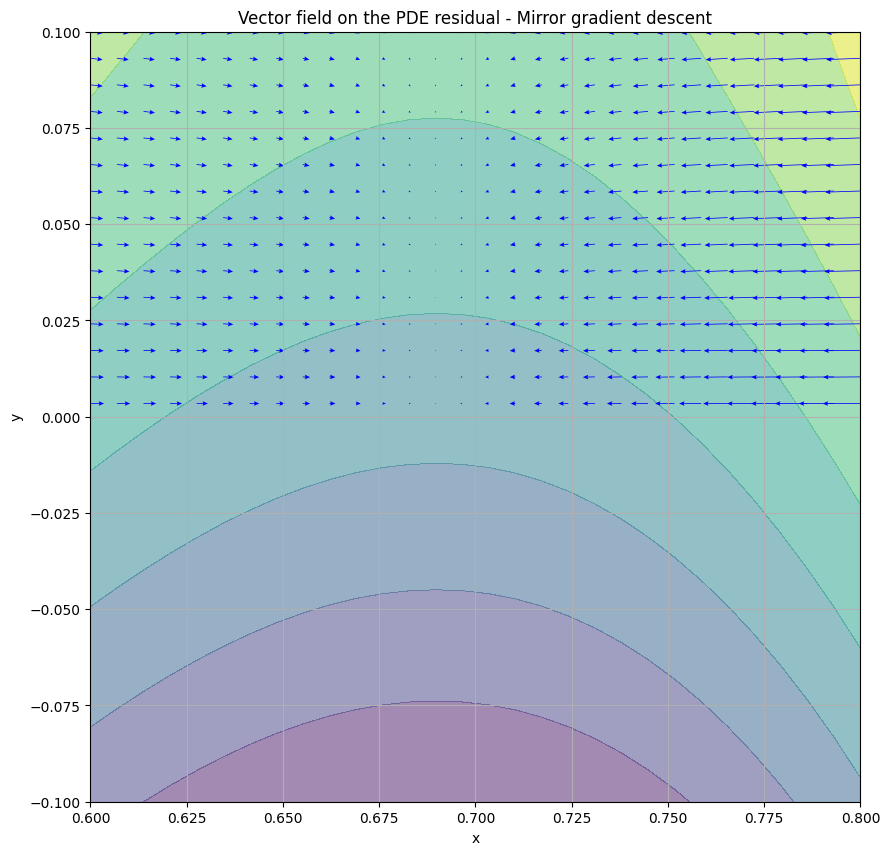

In [155]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming the same scalarized loss function as before
def scalarisedLossFunction(x, y, beta=0.1):
    def riccatiEquation(z):
        return z**2 - 4 * beta * z - 2 * beta
    loss = np.diag([riccatiEquation(x), riccatiEquation(y)])
    return np.linalg.norm(loss)

# Mirror Descent Update Step
def mirror_descent_step(grad, current_point, learning_rate=0.01):
    # Example: using log-barrier as the mirror map, the update might look like:
    updated_point = np.exp(np.log(current_point + 1e-8) - learning_rate * grad)
    return updated_point

# Compute gradient as before
def compute_gradient(f, x, y, beta, h=1e-5):
    dfdx = (f(x + h, y, beta) - f(x - h, y, beta)) / (2 * h)
    dfdy = (f(x, y + h, beta) - f(x, y - h, beta)) / (2 * h)
    return np.array([dfdx, dfdy])

# Generate a grid of points
x_values = np.linspace(0.6, 0.8, 30)
y_values = np.linspace(-0.1, 0.1, 30)
X, Y = np.meshgrid(x_values, y_values)

# Prepare storage for vectors showing mirror descent directions
U = np.zeros_like(X)
V = np.zeros_like(Y)

# Apply mirror descent step to each grid point
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        current_point = np.array([X[i, j], Y[i, j]])
        grad = compute_gradient(scalarisedLossFunction, X[i, j], Y[i, j], beta=0.1)
        updated_point = mirror_descent_step(grad, current_point)
        U[i, j] = updated_point[0] - current_point[0]
        V[i, j] = updated_point[1] - current_point[1]

# Plot the vector field using quiver
plt.figure(figsize=(10, 10))
# Optionally, overlay contour lines of the scalarized loss function
Z = np.array([[scalarisedLossFunction(x, y, beta=0.1) for x in x_values] for y in y_values])
plt.contourf(X, Y, Z, alpha=0.5)

plt.quiver(X, Y, U, V, color='blue', scale=0.1, scale_units='width', width=0.001, 
           headwidth=6, headlength=7, headaxislength=6)
# Ensure the x-axis and y-axis have the same scale
plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Vector field on the PDE residual - Mirror gradient descent')
plt.grid(True)
plt.show()

# Hessian Cucker Smale 

In [31]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

T = 10
dt = 0.1
dim = 1

# n_samples = 1
# barx = 2 * torch.rand((n_samples, 2 * dim), requires_grad=True).to(device)

gridPoints = np.meshgrid(*[np.linspace(-1, 1, 10) for _ in range(2)])
gridPoints = np.stack(gridPoints, axis=-1).reshape(-1, 2)

barx = torch.tensor(gridPoints)
print(barx.shape)

B = torch.vstack( [torch.zeros((dim, dim)), torch.eye(dim)] ).to(device).float()
Q = 1 / dim * torch.eye(2*dim, 2*dim).to(device).float()
R = 1 / dim * torch.eye(dim, dim).to(device).float()
beta = pde.beta

Bnp = B.cpu().numpy()
Qnp = Q.cpu().numpy()
Rnp = R.cpu().numpy()

torch.Size([100, 2])


In [32]:
resu = {}
save_u = {}
value_function = []
for sample in range(barx.shape[0]):
    new_barx_i = barx[sample, :].cpu().detach().numpy()
    save_barx_i = np.zeros( (100, 2 * dim) )
    save_u_i = np.zeros( (100, dim) )
    
    for i, t in enumerate( np.arange(0, T, dt) ):
        barx_i = new_barx_i
        A_small = buildMatrixA(y=barx_i[0 : dim])
        A = np.block( [[ np.zeros((dim, dim)), np.eye(dim)], [np.zeros((dim, dim)), A_small]] )

        # compute the control
        P = scipy.linalg.solve_continuous_are(A, Bnp, Qnp, Rnp)
        baru = - 1 / (2 * beta) * np.linalg.inv(Rnp) @ Bnp.T @ P @ barx_i
        save_barx_i[i] = new_barx_i
        save_u_i[i] = baru
        
        # compute the dynamics
        new_barx_i = barx_i + A @ barx_i * dt + np.squeeze(Bnp @ baru) * dt
        
    # save the value function
    vi = np.sum( np.trapezoid(y=save_barx_i**2, dx=dt, axis=0) ) + np.sum( np.trapezoid(y=np.squeeze( save_u_i**2 ), dx=dt, axis=0) )

    resu[sample] = save_barx_i
    save_u[sample] = save_u_i
    value_function.append( vi )

(10, 10)


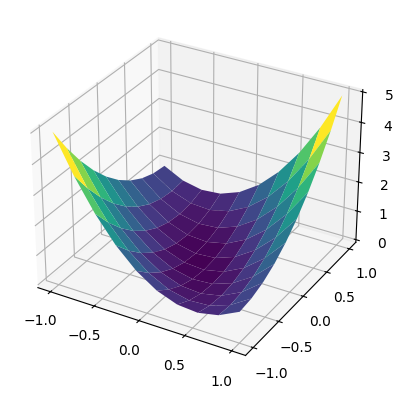

In [33]:
x = np.linspace(-1, 1, 10)
y = np.linspace(-1, 1, 10)

X, Y = np.meshgrid(x, y)

Z = np.array(value_function).reshape(-1, 10)
print(Z.shape)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis');

### Hessian approximation

In [278]:
def compute_value_function(barx_single, dim):
    new_barx_i = barx_single.cpu().detach().numpy()
    save_barx_i = np.zeros((100, 2 * dim))
    save_u_i = np.zeros((100, dim))

    for i, t in enumerate(np.arange(0, T, dt)):
        barx_i = new_barx_i
        A_small = buildMatrixA(y=barx_i[0:dim])  # Assuming buildMatrixA is defined elsewhere
        A = np.block([[np.zeros((dim, dim)), np.eye(dim)], [np.zeros((dim, dim)), A_small]])

        # Compute control
        P = scipy.linalg.solve_continuous_are(A, Bnp, Qnp, Rnp)
        baru = -1 / (2 * beta) * np.linalg.inv(Rnp) @ Bnp.T @ P @ barx_i
        save_barx_i[i] = new_barx_i
        save_u_i[i] = baru

        # Compute dynamics
        new_barx_i = barx_i + A @ barx_i * dt + np.squeeze(Bnp @ baru) * dt

    # Compute and return the value function for this sample
    vi = np.sum(np.trapezoid(y=save_barx_i**2, dx=dt, axis=0)) + np.sum(np.trapezoid(y=np.squeeze(save_u_i**2), dx=dt, axis=0))
    return vi

In [279]:
def compute_hessian(value_function, barx, dim, epsilon=1e-4):
    hessian = np.zeros((dim, dim))

    # Compute value function at the original point
    f0 = value_function(barx, dim)

    # Loop through each dimension to compute the second-order partial derivatives
    for i in range(dim):
        for j in range(dim):
            # Perturb barx in the i-th and j-th dimensions
            barx_ij = barx.clone()
            barx_ij[i] += epsilon
            barx_ij[j] += epsilon
            
            barx_i = barx.clone()
            barx_i[i] += epsilon

            barx_j = barx.clone()
            barx_j[j] += epsilon

            # Compute value function at perturbed points
            f_ij = value_function(barx_ij, dim)
            f_i = value_function(barx_i, dim)
            f_j = value_function(barx_j, dim)

            # Approximate second partial derivative
            hessian[i, j] = (f_ij - f_i - f_j + f0) / (epsilon ** 2)

    return hessian


In [280]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

T = 10
dt = 0.1
dim = 1

barx = torch.tensor([0.5, -0.2, 0.3, -0.1], device=device)  # A single sample point in 4D space
print(barx.shape)

B = torch.vstack([torch.zeros((dim, dim)), torch.eye(dim)]).to(device).float()
Q = 1 / dim * torch.eye(2 * dim, 2 * dim).to(device).float()
R = 1 / dim * torch.eye(dim, dim).to(device).float()
beta = pde.beta

Bnp = B.cpu().numpy()
Qnp = Q.cpu().numpy()
Rnp = R.cpu().numpy()

torch.Size([4])


In [283]:
import numpy as np
import torch
from tqdm import tqdm

# Define your compute_value_function and compute_hessian here (from previous code)

# Define the space [0, 1]^4
n_points_per_dim = 100  # Number of points per dimension

# Generate a grid in [0,1]^4
gridPoints = np.meshgrid(*[np.linspace(-1, 1, n_points_per_dim) for _ in range(2 * dim)])
gridPoints = np.stack(gridPoints, axis=-1).reshape(-1, 2*dim)  # Reshape to get a list of 4D points

# List to store non-convex points
# non_convex_points = []
resu = []
# Loop through each point in the grid using tqdm to show progress
for idx, point in enumerate(tqdm(gridPoints, desc="Checking convexity")):
    barx_single = torch.tensor(point, device=device).float()  # Convert point to torch tensor
    
    # Compute Hessian at this point
    hessian = compute_hessian(compute_value_function, barx_single, dim)
    
    # Check eigenvalues for convexity
    eigenvalues = np.linalg.eigvals(hessian)
    is_convex = np.all(eigenvalues >= 0)
    
    resu.append({'point': point, 'minEigenvalues': np.min(eigenvalues), 'is_convex': is_convex})

Checking convexity: 100%|██████████| 10000/10000 [14:00<00:00, 11.89it/s]


In [284]:
resu = pd.DataFrame( resu )

In [285]:
resu[~resu['is_convex']]

,point,minEigenvalues,is_convex


In [129]:
non_convex_points = resu[~resu['is_convex']]['point']
non_convex_points = np.vstack(non_convex_points.to_numpy())

In [131]:
non_convex_points.shape

(104, 4)

/var/folders/x3/rv50w10j3md436d0633nrr600000gn/T/ipykernel_25910/822353111.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('inferno', len(non_convex_points))  # Choose a colormap with as many colors as points


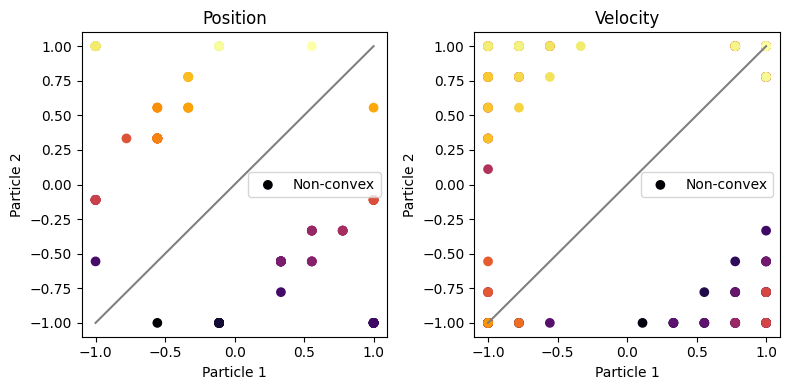

In [241]:
import matplotlib.cm as cm

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

color_map = cm.get_cmap('inferno', len(non_convex_points))  # Choose a colormap with as many colors as points
color_point = []
for i in range(len(non_convex_points)):
    color_point.append(color_map(i))
color_point = np.array(color_point)

ax = axs[0]
ax.scatter(non_convex_points[:, 0], non_convex_points[:, 1], color=color_point, label='Non-convex')
ax.plot([-1, 1], [-1, 1], color='grey')
ax.set_xlabel('Particle 1')
ax.set_ylabel('Particle 2')
ax.set_title('Position')
ax.legend();

ax = axs[1]
ax.scatter(non_convex_points[:, 2], non_convex_points[:, 3], color=color_point, label='Non-convex')
ax.plot([-1, 1], [-1, 1], color='grey')
ax.set_xlabel('Particle 1')
ax.set_ylabel('Particle 2')
ax.set_title('Velocity')
ax.legend();

fig.tight_layout()

/var/folders/x3/rv50w10j3md436d0633nrr600000gn/T/ipykernel_25910/1247717149.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('inferno', len(non_convex_points))  # Choose a colormap with as many colors as points


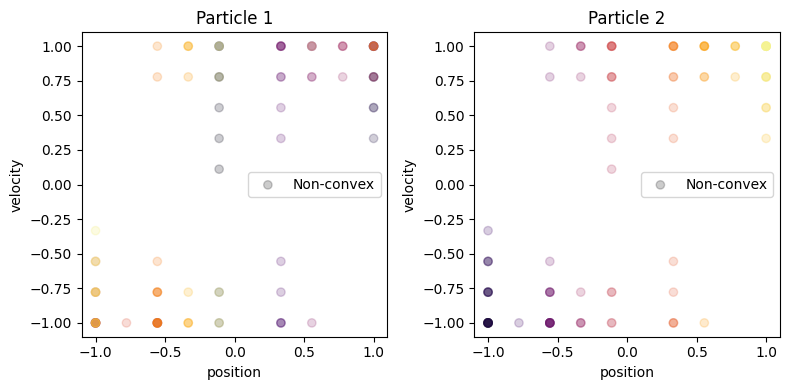

In [242]:
# Convert list to numpy array for easy manipulation
non_convex_points = np.array(non_convex_points)

# Assuming you're interested in projecting the first two dimensions
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

color_map = cm.get_cmap('inferno', len(non_convex_points))  # Choose a colormap with as many colors as points

color_point = []

for i in range(len(non_convex_points)):
    color_point.append(color_map(i))
color_point = np.array(color_point)

ax = axs[0]
ax.scatter(non_convex_points[:, 0], non_convex_points[:, 2], color=color_point, label='Non-convex', alpha=0.2)
ax.set_xlabel('position')
ax.set_ylabel('velocity')
ax.set_title('Particle 1')
ax.legend()

ax = axs[1]
ax.scatter(non_convex_points[:, 1], non_convex_points[:, 3], color=color_point, label='Non-convex', alpha=0.2)
ax.set_xlabel('position')
ax.set_ylabel('velocity')
ax.set_title('Particle 2')
ax.legend();

fig.tight_layout()

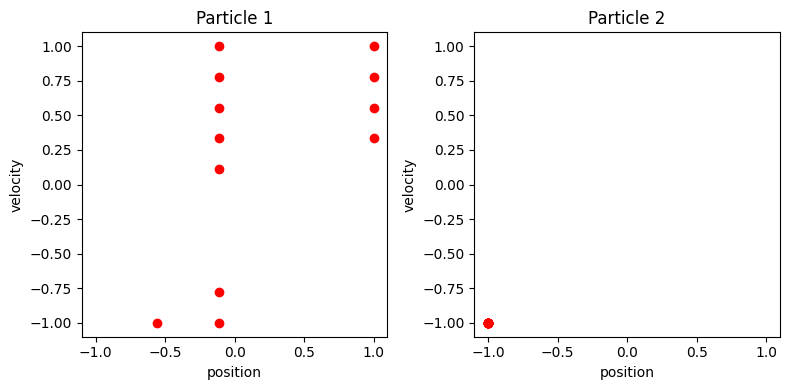

In [243]:
import matplotlib.cm as cm

non_convex_points = np.array(non_convex_points)
unique_points = [p for p in non_convex_points if (p[1] == -1 and p[3] == -1)]
colors = cm.rainbow(np.linspace(0, 1, len(unique_points)))

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
ax = axs[0]
for idx in range(len(unique_points)):
    ax.scatter(unique_points[idx][0], unique_points[idx][2], color='red')
ax.set_xlabel('position')
ax.set_ylabel('velocity')
ax.set_title('Particle 1')
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)

ax = axs[1]
for idx in range(len(unique_points)):
    ax.scatter(unique_points[idx][1], unique_points[idx][3], color='red')
ax.set_xlabel('position')
ax.set_ylabel('velocity')
ax.set_title('Particle 2')
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)

fig.tight_layout()

In [253]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

T = 10
dt = 0.1
dim = 2

barx = torch.tensor(unique_points, requires_grad=True).to(device)
print(barx.shape)

B = torch.vstack( [torch.zeros((dim, dim)), torch.eye(dim)] ).to(device).float()
Q = 1 / dim * torch.eye(2*dim, 2*dim).to(device).float()
R = 1 / dim * torch.eye(dim, dim).to(device).float()
beta = pde.beta

Bnp = B.cpu().numpy()
Qnp = Q.cpu().numpy()
Rnp = R.cpu().numpy()

torch.Size([12, 4])


In [255]:
resu_sdre, save_u_sdre, v_sdre = computeTrajectoriesSDRE( barx, dim )

In [267]:
def plotPosition(ax, idx):
    for i in range(dim):
        ax.plot( np.linspace(0, T, 100), resu_sdre[idx][:, i] )
    ax.set_xlabel('Time')
    ax.set_ylabel('Position')
    ax.axhline(0, color='grey', lw=0.5)
    ax.grid(alpha=0.2)
    
def plotVelocity(ax, idx):
    for i in range(dim, 2 * dim):
        ax.plot( np.linspace(0, T, 100), resu_sdre[idx][:, i] )
    ax.set_xlabel('Time')
    ax.set_ylabel('Velocity')
    ax.axhline(0, color='grey', lw=0.5)
    ax.grid(alpha=0.2)
    
def plotControl(ax, idx):
    for i in range(dim):
        ax.plot( np.linspace(0, T, 100), save_u_sdre[idx][:, i] )
    ax.set_xlabel('Time')
    ax.set_ylabel('Control')
    ax.axhline(0, color='grey', lw=0.5)
    ax.grid(alpha=0.2)

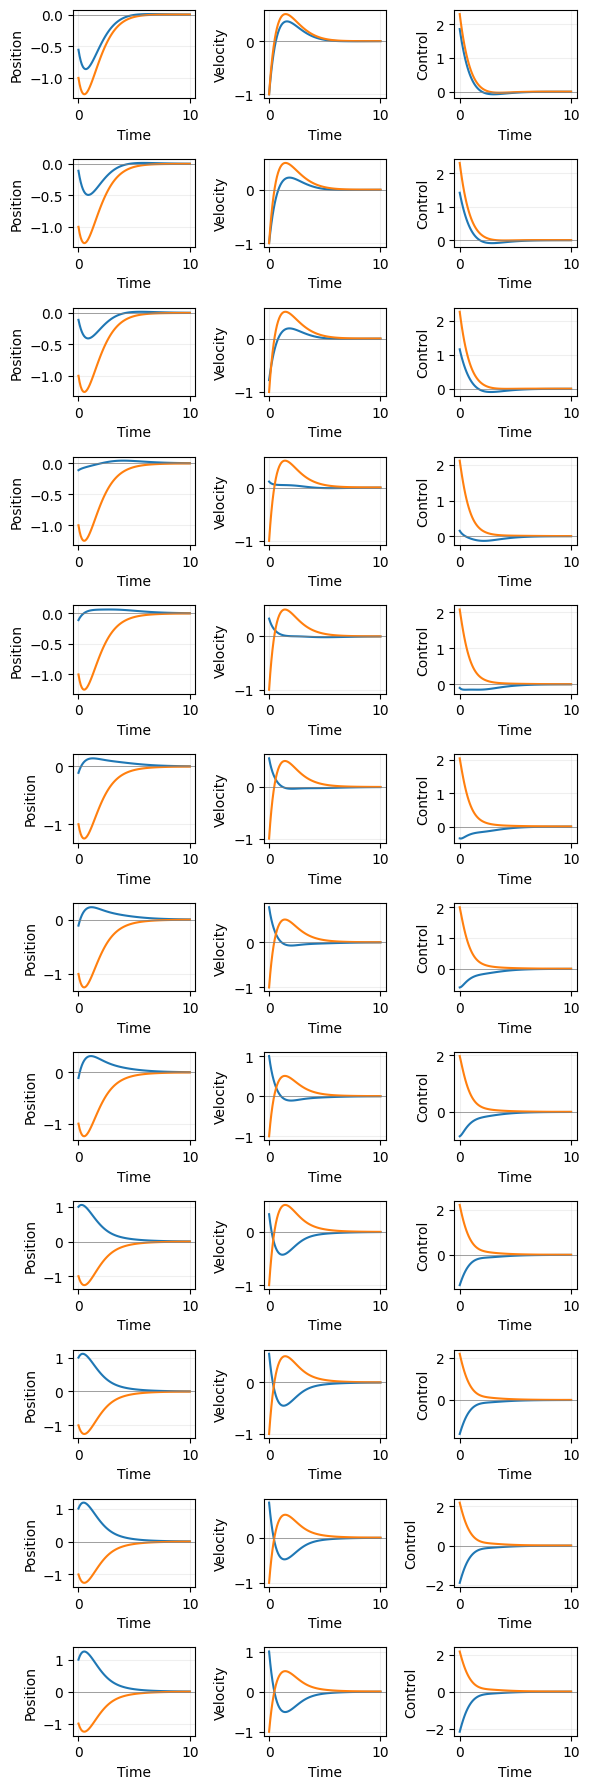

In [271]:
fig, axes = plt.subplots(12, 3, figsize=(6, 18))

for i, axs in enumerate(axes):
        
    ax = axs[0]
    plotPosition(ax, i)
    
    ax = axs[1]
    plotVelocity(ax, i)
    
    ax = axs[2]
    plotControl(ax, i)
    
    fig.tight_layout()